<a href="https://colab.research.google.com/github/selvaarakshun/selvaarakshun/blob/main/R0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tsplib95 networkx scipy matplotlib


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload the 'ar9152.tsp' file from your local system


Saving ar9152.tsp to ar9152 (2).tsp


In [3]:
import tsplib95
import numpy as np

def load_tsp_data(filename, subset_size=100):  # Limit the number of cities to 100 for better performance
    problem = tsplib95.load(filename)
    cities = list(problem.get_nodes())[:subset_size]  # Limit the number of cities for testing
    coordinates = np.array([problem.node_coords[city] for city in cities])
    return cities, coordinates

# Load a subset of the data (adjust the number of cities as needed)
filename = 'ar9152.tsp'  # Ensure that you have uploaded 'ar9152.tsp'
cities, coordinates = load_tsp_data(filename)
print(f"Loaded {len(cities)} cities")


Loaded 100 cities


In [4]:
from scipy.spatial.distance import cdist

def calculate_sparse_distance_matrix(coordinates):
    # Use cdist to compute the Euclidean distance matrix efficiently
    return cdist(coordinates, coordinates, metric='euclidean')

distance_matrix = calculate_sparse_distance_matrix(coordinates)
print(f"Distance matrix shape: {distance_matrix.shape}")


Distance matrix shape: (100, 100)


Tour: [0, 83, 94, 54, 34, 72, 75, 95, 74, 18, 35, 69, 71, 12, 98, 60, 70, 82, 39, 84, 90, 45, 93, 44, 41, 1, 21, 47, 27, 65, 33, 49, 51, 92, 7, 23, 22, 43, 17, 85, 86, 68, 4, 38, 81, 64, 99, 50, 10, 40, 19, 89, 87, 63, 52, 91, 55, 5, 79, 25, 6, 78, 77, 62, 56, 2, 57, 3, 48, 24, 26, 73, 29, 80, 61, 88, 9, 42, 16, 97, 8, 15, 76, 14, 67, 20, 11, 28, 46, 59, 66, 96, 37, 31, 58, 13, 53, 30, 32, 36]
Total tour length: 408112.2361846682


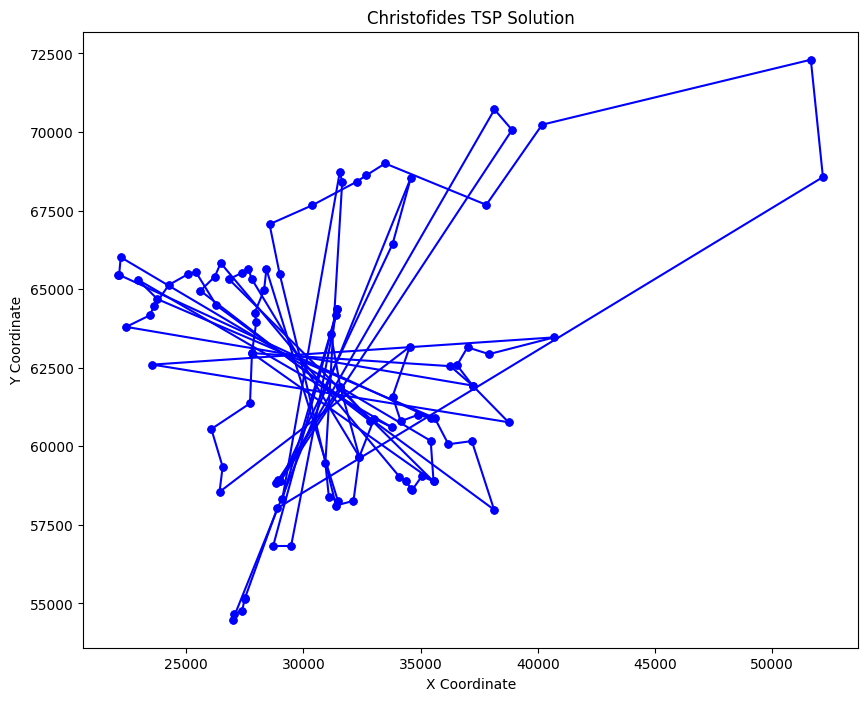

In [7]:
import tsplib95
import numpy as np
import networkx as nx
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree
import matplotlib.pyplot as plt
from itertools import permutations


def load_tsp_data(filename, subset_size=100):  # Limit the number of cities to 100 for better performance
    problem = tsplib95.load(filename)
    cities = list(problem.get_nodes())[:subset_size]  # Limit the number of cities for testing
    coordinates = np.array([problem.node_coords[city] for city in cities])
    return cities, coordinates


def calculate_sparse_distance_matrix(coordinates):
    # Use cdist to compute the Euclidean distance matrix efficiently
    return cdist(coordinates, coordinates, metric='euclidean')


def christofides_algorithm(distance_matrix):
    # Step 1: Create a Minimum Spanning Tree (MST) using Prim's Algorithm
    graph = nx.Graph()
    num_cities = len(distance_matrix)

    # Add nodes and edges to the graph with distances as weights
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            graph.add_edge(i, j, weight=distance_matrix[i][j])

    # Convert the distance matrix to the correct format for scipy
    graph_matrix = np.array(distance_matrix, dtype=np.float64)

    # Get MST using minimum spanning tree algorithm
    mst = minimum_spanning_tree(graph_matrix)
    mst = nx.from_scipy_sparse_array(mst)

    # Step 2: Find odd degree vertices in the MST
    odd_degree_nodes = [node for node, degree in mst.degree() if degree % 2 != 0]

    if len(odd_degree_nodes) == 0:
        print("All vertices have even degrees, no matching required.")

    # Step 3: Find minimum-weight perfect matching for odd degree vertices
    # Create a subgraph containing only the odd degree nodes
    odd_subgraph = nx.Graph()
    for i in range(len(odd_degree_nodes)):
        for j in range(i + 1, len(odd_degree_nodes)):
            node1, node2 = odd_degree_nodes[i], odd_degree_nodes[j]
            odd_subgraph.add_edge(node1, node2, weight=distance_matrix[node1][node2])

    # Find the minimum-weight perfect matching using a greedy approach
    matching = nx.algorithms.matching.max_weight_matching(odd_subgraph, maxcardinality=True)

    # Step 4: Combine MST and the perfect matching
    combined_graph = mst.copy()
    for edge in matching:
        combined_graph.add_edge(edge[0], edge[1], weight=distance_matrix[edge[0]][edge[1]])

    # Step 5: Ensure the graph is Eulerian (must have all even degree vertices)
    if not nx.is_eulerian(combined_graph):
        print("The graph is not Eulerian, adding edges to ensure Eulerian.")
        combined_graph = nx.eulerize(combined_graph)  # Make sure the graph is Eulerian

    # Step 6: Create an Eulerian circuit
    eulerian_circuit = list(nx.eulerian_circuit(combined_graph))

    # Step 7: Convert Eulerian circuit into a Hamiltonian circuit
    # Remove repeated cities in the Eulerian circuit to form the final Hamiltonian tour
    tour = []
    visited = set()
    for u, v in eulerian_circuit:
        if u not in visited:
            tour.append(u)
            visited.add(u)

    # Calculate the total tour length
    tour_length = sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
    # Add the distance from the last city to the first city
    tour_length += distance_matrix[tour[-1], tour[0]]

    return tour, tour_length


# Load and prepare data
filename = 'ar9152.tsp'  # Ensure that you have uploaded 'ar9152.tsp'
cities, coordinates = load_tsp_data(filename)

# Calculate the distance matrix
distance_matrix = calculate_sparse_distance_matrix(coordinates)

# Run the Christofides Algorithm
tour, tour_length = christofides_algorithm(distance_matrix)

# Print the results
print(f"Tour: {tour}")
print(f"Total tour length: {tour_length}")

# Visualize the TSP solution (optional)
def plot_tsp_solution(tour, coordinates):
    plt.figure(figsize=(10, 8))
    for i in range(len(tour)-1):
        city1 = tour[i]
        city2 = tour[i+1]
        plt.plot([coordinates[city1][0], coordinates[city2][0]], [coordinates[city1][1], coordinates[city2][1]], 'bo-', markersize=5)
    # Add the final edge from the last city to the first city
    plt.plot([coordinates[tour[-1]][0], coordinates[tour[0]][0]], [coordinates[tour[-1]][1], coordinates[tour[0]][1]], 'bo-', markersize=5)

    plt.title('Christofides TSP Solution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

plot_tsp_solution(tour, coordinates)
